# Analyzing NYC Taxifare Dataset 

**Objectives**
- Run a query on BigQuery
- Sample from large dataset in a reproducible way
- Explore data using Spark DataFrame
- Identify corrupt data and clean accordingly

## Introduction 
In this notebook, we will explore a dataset corresponding to taxi rides in New York City to build a Machine Learning model that estimates taxi fares. The idea is to suggest an expected fare to taxi riders. Such a model would also be useful for ride-hailing apps that quote you the trip price in advance.

### Load necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import time
from joblib import dump, load

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Check that the Google BigQuery library is installed and if not, install it.
!pip freeze | grep google-cloud-bigquery || pip install google-cloud-bigquery

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

from pyspark.sql import SparkSession

from pyspark.sql import types as sType
from pyspark.sql import functions as sFuncs
from pyspark.sql.window import Window

google-cloud-bigquery==1.26.1
google-cloud-bigquery-storage==1.0.0


### Set up environment variables

In [2]:
# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)


PROJECT = "saberbf-2020"  # Replace with your PROJECT
REGION = "us-east1"       # Choose an available region for Cloud MLE
BUCKET = "gs://saberbf0098/"

os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = BUCKET


%reload_ext google.cloud.bigquery


## Preview data

The NYC taxi cab dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/) under `nyc-tlc.yellow.trips`. It is a publically available dataset with a GCP account (click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to acess the dataset). Here is a few details about this dataset quoted from BigQuerry:

---
"This dataset includes trip records from all trips completed in yellow taxis in NYC from 2009 to 2018.  Records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the **NYC Taxi and Limousine Commission (TLC)** by technology providers authorized under the Taxicab Passenger Enhancement Program (TPEP).  The  trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data."

|Desc| Values |
| - | - | 
| Project/Catalog name | nyc-tlc |
| Dataset name | yellow |
| Table name | trips |
| Table size | 129.72 GB |
| Number of rows | 1,108,779,463 |
| Created | Sep 25, 2015, 2:29:01 PM |

---
There are over 1 Billion rows in this dataset and it's 130GB large; a real meaning of Big Data!!!

Now let's take a look at the schema of the table:


In [3]:
%%bigquery --project $PROJECT
#standardSQL
SELECT
    * EXCEPT(table_catalog, table_schema, table_name)
FROM
    `nyc-tlc.yellow`.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE 
    TABLE_NAME = 'trips'

,column_name,field_path,data_type,description
0,vendor_id,vendor_id,STRING,A designation for the technology vendor that p...
1,pickup_datetime,pickup_datetime,TIMESTAMP,The date and time when the meter was engaged.
2,dropoff_datetime,dropoff_datetime,TIMESTAMP,The date and time when the meter was disengaged.
3,pickup_longitude,pickup_longitude,FLOAT64,Longitude where the meter was engaged.
4,pickup_latitude,pickup_latitude,FLOAT64,Latitude where the meter was engaged.
5,dropoff_longitude,dropoff_longitude,FLOAT64,Longitude where the meter was disengaged.
6,dropoff_latitude,dropoff_latitude,FLOAT64,Latitude where the meter was disengaged.
7,rate_code,rate_code,STRING,The final rate code in effect at the end of th...
8,passenger_count,passenger_count,INT64,The number of passengers in the vehicle. \n\n...
9,trip_distance,trip_distance,FLOAT64,The elapsed trip distance in miles reported by...


As we saw above, the dataset is super big. It doesn't seem to be reasonable to load the whole dataset into the memory, just for exploration purposes, neither it does seem to be fit into the memory. Thus, an alternative is to sample uniformly from the whole population. 

To sample the data deterministicly, we can use either a uniform random number generator or we can use a hash function. The problem is that BigQuery has a limited number of functions for "standardSQL". RAND() is the only function that we may want to use, but you can't select a seed for that. Thus we are left with hash option. 

**Observation:** I noticed a lot faster sampling operation with hash function compared to RAND()

We use a hash function and then sample using the modulo operation on the hashed value. The hash values are obtained using:

`FARM_FINGERPRINT(CAST(hashkey AS STRING))`

Where:

- `FARM_FINGERPRINT()`: Hashes strings to 64bit integers
- `CAST()`: Casts hashkey to string

Given these properties we can sample our data repeatably using the modulo operation. We'll use `pickup_datetime` as our hash key because it meets our desired properties. If such a column doesn't exist in the data you can synthesize a hashkey by concatenating multiple columns. Below we sample 1/5000th of the data. Then we store the samples in a [Pandas](https://pandas.pydata.org/) DataFrame.

In [4]:
bq = bigquery.Client(project=PROJECT)

query_string = """
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
Where
    -- repeatable 1/5000th sample
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 5000)) = 1
"""

trips = bq.query(query_string).to_dataframe()
trips.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,VTS,2009-04-09 11:39:00+00:00,2009-04-09 11:40:00+00:00,-73.968222,40.765383,-73.968255,40.765235,None,5,0.02,CSH,2.5,0.0,NaN,NaN,0.0,0.0,2.5,None
1,CMT,2015-06-20 12:28:17+00:00,2015-06-20 12:28:26+00:00,-74.014740,40.709801,-74.014938,40.709732,1,1,0.00,CSH,2.5,0.0,0.5,0.3,0.0,0.0,3.3,N
2,VTS,2014-03-16 16:52:00+00:00,2014-03-16 16:54:00+00:00,-73.965965,40.794857,-73.968460,40.791497,1,1,0.28,CSH,3.0,0.0,0.5,NaN,0.0,0.0,3.5,None
3,CMT,2014-12-06 19:12:34+00:00,2014-12-06 19:14:34+00:00,-73.968262,40.767885,-73.963557,40.774240,1,1,0.50,CSH,3.5,0.0,0.5,NaN,0.0,0.0,4.0,N
4,CMT,2014-07-15 21:47:28+00:00,2014-07-15 21:50:08+00:00,-73.995618,40.726612,-73.995471,40.723320,1,1,0.30,CSH,3.5,0.5,0.5,NaN,0.0,0.0,4.5,N


It would be useful to understand the distribution of each of our columns, which is to say the mean, min, max, standard deviation etc..

In [5]:
# trips.describe(include='all')
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount
count,224010.000000,224010.000000,224008.000000,224008.000000,224010.000000,224010.000000,224010.000000,224010.000000,193917.000000,15103.000000,224010.000000,224010.000000,224010.000000
mean,-72.567277,39.975019,-72.568600,39.953818,1.687076,2.830173,11.127325,0.287398,0.496207,0.297239,1.092133,0.215548,13.173473
std,17.184744,11.531709,14.173995,12.181259,1.317762,3.307880,9.095850,0.348067,0.047469,0.028856,1.951176,1.087451,10.879476
min,-3327.388155,-2108.147765,-2084.468870,-2587.703973,0.000000,0.000000,-52.000000,-0.500000,-1.000000,-0.300000,0.000000,0.000000,-52.800000
25%,-73.992087,40.735032,-73.991471,40.734159,1.000000,1.020000,6.000000,0.000000,0.500000,0.300000,0.000000,0.000000,7.150000
50%,-73.981826,40.752635,-73.980220,40.753110,1.000000,1.750000,8.500000,0.000000,0.500000,0.300000,0.000000,0.000000,10.000000
75%,-73.967239,40.767140,-73.963937,40.768102,2.000000,3.140000,12.500000,0.500000,0.500000,0.300000,1.720000,0.000000,14.600000
max,3442.185068,2614.663005,3442.185068,2958.581502,49.000000,97.300000,412.640000,1.500000,0.500000,0.300000,100.000000,23.500000,412.640000


At the first glance, we notice that: 

- `min` and `max` of Latitudes (should be between -90 and 90), and longitudes (should be between -180 and 180) are off the range, so clearly some of this data is misleading and should be removed or corrected.

- some trip fares are negative and some passenger counts are 0 which doesn't seem right. They need to be cleaned up.

- some trip distances are 0, but it appears that passengers are being charged substantial fares, despite. To remove them from the query, we only keep trips longer than zero miles and fare amounts bigger than ($2.50). 

- We can combine the sum of `fare_amount` and `tolls_amount` into a the `fare_amount`. Excluding tip, based on the distance that the passenger is traveling with the taxi, `fare_amount` is the total amount is expected to paid.

### Data Visulaization
Let's visualize the data. For this purpose, we scatter plot `trip_distance` vs `fare_amount`. Also, there might be some infromation in the histogram of the data. Thus, we plot histogram of `fare_amount` to understand the distribution of the data.

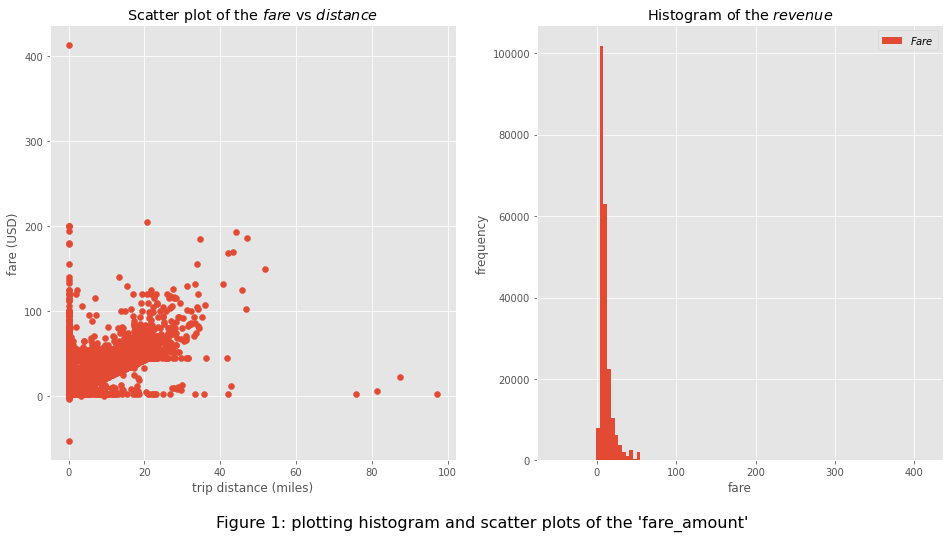

In [6]:
#Plotting

num_bins = 100

#creating plot axes
fig = plt.figure(figsize=(16,8))
caption = "Figure 1: plotting histogram and scatter plots of the 'fare_amount'"
fig.text(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=16)
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122) 


# the scatterplot of the 'fare_amount'
ax1.scatter(x=trips.trip_distance, y=trips['fare_amount'], label="$Fare$")
# ax1.legend()
ax1.set_xlabel('trip distance (miles)')
# ax1.set_xlim(0,100)
ax1.set_ylabel('fare (USD)')
ax1.set_title('Scatter plot of the $fare$ vs $distance$');

# the histogram of the 'fare_amount'
ax2.hist(trips['fare_amount'], bins=num_bins, label="$Fare$")
ax2.legend()
ax2.set_xlabel('fare')
# ax2.set_xlim(0,100)
ax2.set_ylabel('frequency')
ax2.set_title('Histogram of the $revenue$');

The histogram plot in Figure 1 shows that distribution of the `fare_amount` is not Normal. In fact, it seems that a pattern of 'exponential decay' is proposed by the histogram of the `fare_amount`. Thus, the suggestion is to use $\mathbf{\log()}$ to transform the fare data. If the resulting transformed data leads to a Normal distribution, then some linear regression models, that assume normal underlaying distribution for data, can be used to detect outlayers.

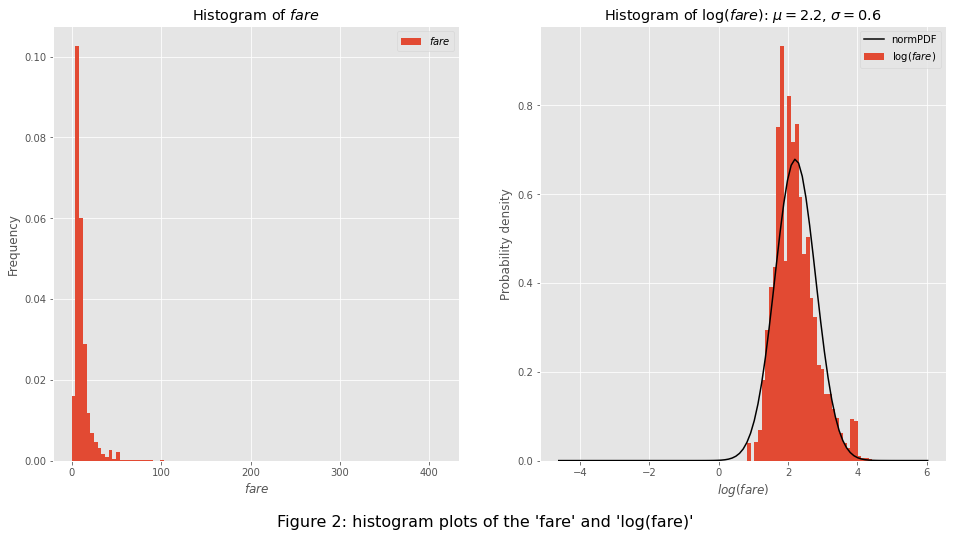

In [7]:
# to plot histogram of "fare"

# normal pdf function
# alternatively I could have used scipy package but to limit dependencies a function is defined
def normalpdf(x, mu=0.0, sigma=1.0):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

# create log transform of the 'fare'
# trips['log_fare'] = np.log(trips['fare_amount']+1)

# 'fare' and its log transform for the values which are not zero
fare = trips[['fare_amount']].loc[trips.fare_amount>0]
log_fare = np.log(fare) #trips[['log_fare']].loc[trips.log_fare>0]

# mean of the 'log(fare)' distribution
mu = float(log_fare.mean())
# standard deviation of the 'log(fare)' distribution
sigma = float(log_fare.std())

num_bins = 100



#Plotting

#creating plot axes
fig = plt.figure(figsize=(16,8))
caption = "Figure 2: histogram plots of the 'fare' and 'log(fare)'"
fig.text(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=16)
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122) 

# the histogram of the 'fare'
ax1.hist(fare, bins=num_bins, density=True, label="$fare$")
ax1.legend()
ax1.set_xlabel('$\it{fare}$')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of $\it{fare}$')



# the histogram of the 'log(fare)'
(_, bins, _) = ax2.hist(log_fare, bins=num_bins, density=True, label="$\log(fare)$") 
#Compute probability density function
normPDF = normalpdf(bins, mu, sigma)
ax2.plot(bins, normPDF, label="normPDF", color='black')
ax2.legend()
ax2.set_xlabel('$log(fare)$')
ax2.set_ylabel('Probability density')
ax2.set_title('Histogram of $\log(fare)$: $\mu={:.1f}$, $\sigma={:.1f}$'.format(mu, sigma));

# Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# plt.show()

The transformed data seems to show Normal distribution properties. Thus, it would be reasonable to use standard Normal scaling to find outlayers and discard them.

### Select useful fields

What fields do you see that may be useful in modeling taxifare? They should be

1. Related to the objective: for example we know `passenger_count` shouldn't have any affect on fare because fare is calculated by time and distance.
2. Available at prediction time: for example `trip_distance` is certainly related to the objective, but not available until a trip is completed

We will use `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `trip_distance`.

### Clean the data

Based on what we discussed so far, here is the proposed clean-up process for the data:

- Filter to latitudes and longitudes that are reasonable for NYC
- Throw out fare amounts < $2.50
- Trip distances and passenger counts should be non-zero
- Have the label reflect the sum of `fare_amount` and `tolls_amount`

Let's change the BigQuery query appropriately, and only return the fields we'll use in our model.

In [8]:
query_string = '''
SELECT
    -- add new label
    (tolls_amount + fare_amount) AS total_fare_amount, -- label
    -- select features
    pickup_datetime,
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude, 
    dropoff_latitude,
    trip_distance
FROM
    `nyc-tlc.yellow.trips`
WHERE
    -- Clean Data
    trip_distance > 0
    AND passenger_count > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -74.2
    AND pickup_longitude < -73.7
    AND dropoff_longitude > -74.2
    AND dropoff_longitude < -73.7
    AND pickup_latitude >40.5
    AND pickup_latitude < 41
    AND dropoff_latitude > 40.5
    AND dropoff_latitude < 41
    -- repeatable 1/5000th sample
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 5000)) = 1'''

trips = bq.query(query_string).to_dataframe()
trips.head()

,total_fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance
0,2.5,2014-11-26 00:51:56+00:00,-73.987043,40.739564,-73.955514,40.684206,5.60
1,17.0,2013-10-11 23:18:00+00:00,-73.999283,40.731435,-73.948425,40.778192,5.08
2,17.0,2013-01-21 00:08:00+00:00,-73.990015,40.725440,-73.956537,40.675087,4.82
3,18.0,2014-12-22 15:29:27+00:00,-73.991543,40.749563,-73.954441,40.778896,3.30
4,23.0,2013-05-14 08:59:00+00:00,-73.954417,40.774547,-73.992645,40.748257,3.57


### Clustering pickup and dropoff Locations

With a KMeans model, we can cluster pickup and dropoff location.

In [9]:
def make_geographical_features(data):
    
    coarse_clustering, fine_clustering = load("/home/BigData/Final/location_clustering.models")

    print(coarse_clustering.cluster_centers_)
    coarse_clusters= coarse_clustering.predict(trips[["pickup_longitude","pickup_latitude"]])
    per_cluster_data = [trips.loc[coarse_clusters==i] for i in [0,1]]
    fine_clusters = fine_clustering.predict(per_cluster_data[0][["pickup_longitude","pickup_latitude"]])
    
    per_cluster_data[0]["geographical_cluster"] = fine_clusters
    per_cluster_data[1]["geographical_cluster"] = np.zeros(len(per_cluster_data[1]))+np.max(fine_clusters)+1
    full = pd.concat(per_cluster_data)
    return full

[[-73.97885079  40.75261987]
 [-73.79073971  40.6547884 ]]


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


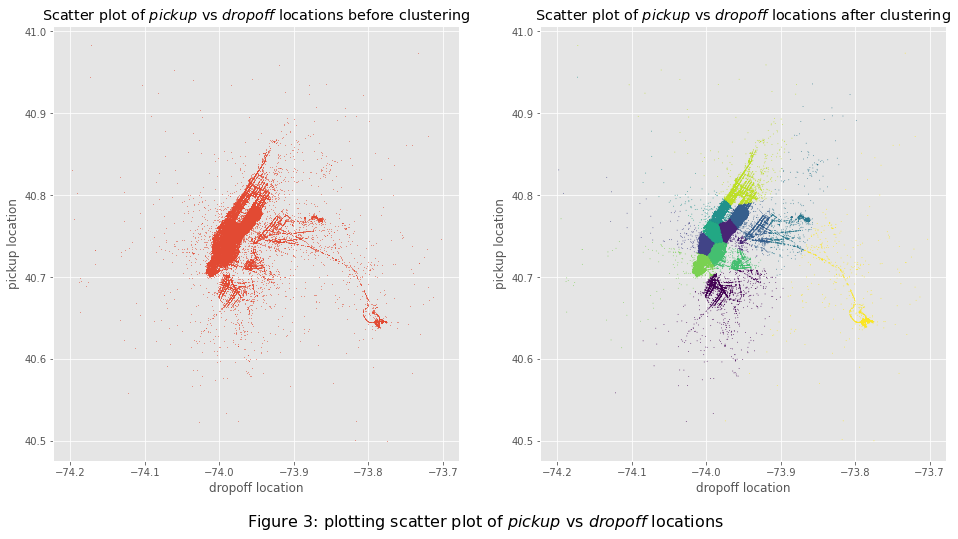

In [10]:
trips_with_cluster = make_geographical_features(trips)

#creating plot axes
fig = plt.figure(figsize=(16,8))
caption = "Figure 3: plotting scatter plot of $pickup$ vs $dropoff$ locations"
fig.text(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=16)
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122) 


# Scatter plot of $pickup$ vs $dropoff$ locations before clustering
ax1.scatter(x=trips.pickup_longitude, y=trips['pickup_latitude'], s=0.1, label="$pickup$")
# ax1.legend()
ax1.set_xlabel('dropoff location')
# ax1.set_xlim(0,100)
ax1.set_ylabel('pickup location')
ax1.set_title('Scatter plot of $pickup$ vs $dropoff$ locations before clustering');


# Scatter plot of $pickup$ vs $dropoff$ locations after clustering
ax2.scatter(x=trips_with_cluster.pickup_longitude, y=trips_with_cluster['pickup_latitude'], \
            s= 0.1, c = trips_with_cluster["geographical_cluster"], label="$pickup$")
# ax2.legend()
ax2.set_xlabel('dropoff location')
# ax2.set_xlim(0,100)
ax2.set_ylabel('pickup location')
ax2.set_title('Scatter plot of $pickup$ vs $dropoff$ locations after clustering');

Instead of using the `trip_distance` entry from the dataset, a better approach could be to use the Eucleadian distance between pickup and dropoff points. Thus we use the below functions:

Features:
- pickup time : scaled time of day --> float (0,1)
- pickup location: Bin locations and one-hot encode
- dropoff location: Bin locations and one-hot encode
- Distance: Crow fly distance, 

In [11]:
def calc_distance(trip):
    
    x1,y1 = trip["pickup_longitude"],trip["pickup_latitude"]
    x2,y2 = trip["dropoff_longitude"],trip["dropoff_latitude"]
    dist = np.sqrt((y2-y1)**2 + (x2-x1)**2)
    return np.nan if dist == 0 else dist

def to_onehot(n,mx):
    res= np.zeros((mx,))
    res[n] = 1
    return res

def entry_to_point(trip):
    values = np.array([trip["pickup_hour"]/12,np.log(trip["crowfly_dist"])])
    onehot_location= to_onehot(int(trip["geographical_cluster"]),11)
    values=  np.concatenate([values,onehot_location])
    return values

In [12]:
trips_with_cluster["pickup_hour"] = [i.hour -12 for i in trips_with_cluster["pickup_datetime"]]
trips_with_cluster["crowfly_dist"] = trips_with_cluster.apply(calc_distance,axis = 1)
trips_with_cluster= trips_with_cluster.dropna()
trips_with_cluster.head()

,total_fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,geographical_cluster,pickup_hour,crowfly_dist
0,2.5,2014-11-26 00:51:56+00:00,-73.987043,40.739564,-73.955514,40.684206,5.60,7.0,-12,0.063707
1,17.0,2013-10-11 23:18:00+00:00,-73.999283,40.731435,-73.948425,40.778192,5.08,2.0,11,0.069085
2,17.0,2013-01-21 00:08:00+00:00,-73.990015,40.725440,-73.956537,40.675087,4.82,7.0,-12,0.060467
3,18.0,2014-12-22 15:29:27+00:00,-73.991543,40.749563,-73.954441,40.778896,3.30,6.0,3,0.047297
4,23.0,2013-05-14 08:59:00+00:00,-73.954417,40.774547,-73.992645,40.748257,3.57,3.0,-4,0.046396


In [13]:
X = trips_with_cluster.apply(entry_to_point,axis = 1).values
X = np.array([x for x in X])

y = trips_with_cluster["total_fare_amount"].values

X[:,1] =( X[:,1] - np.mean(X[:,1]))/np.std(X[:,1])

### Running a linear model on the data
To predict fare, we use Epsilon-Support Vector Regression model from Scikit Learn.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
lreg = Ridge()
lreg.fit(X_train,y_train)
lreg.score(X_test,y_test)

0.6049463985318464

In [ ]:
svr = SVR(cache_size=7000)
svr.fit(X_train,y_train)
svr.score(X_test,y_test)

/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Working on the original dataset

Now that we got some basic intuition about the dataset, it is time to use *Spark* DataFrames to preprocess the data and then train a simple learning model on the data to predict taxi fare for passengers.

### Create Spark Session

The first step would be to import the data into a spark DataFrame.

In practice, when running on a cluster, you will not want to hardcode master in the program, but rather launch the application with spark-submit and receive it there. However, for local testing and unit tests, you can pass “local[\*]” to run Spark Streaming in-process (detects the number of cores in the local system). 

In [16]:
'''
By default, on the GCP, Dataproc utilizes a YARN resource management  
service. In case you are testin your code on a local system, it 
may throw an error when running a YARN master. In this case, our 
experience shows that using a “local[\*]” spark master resolves 
the issue. In such situation, try to add ".master('local[*]')" to 
sparkSession configuraion.
'''

# If you are using Dataproc image 1.5, add the following parameter:
# --jars=gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar
# If you are using Dataproc image 1.4 or below, add the following parameter:
# --jars=gs://spark-lib/bigquery/spark-bigquery-latest.jar
spark = SparkSession.builder \
    .appName('NYCTaxiFarePrediction') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
    .master('yarn') \
    .getOrCreate()

# Use the Cloud Storage bucket for temporary BigQuery export data used
# by the connector.
spark.conf.set('temporaryGcsBucket', BUCKET)

In [17]:
# This will output the results of DataFrames in each step without the 
# new need to show df.show() and also improves the formatting of the output
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [18]:
table = "nyc-tlc.yellow.trips"

cleanup_filter = '''
-- Clean Data
trip_distance > 0
AND passenger_count > 0
AND fare_amount >= 2.5
AND pickup_longitude > -74.2
AND pickup_longitude < -73.7
AND dropoff_longitude > -74.2
AND dropoff_longitude < -73.7
AND pickup_latitude >40.5
AND pickup_latitude < 41
AND dropoff_latitude > 40.5
AND dropoff_latitude < 41
'''

features = (
# add new label
'(tolls_amount + fare_amount) AS total_fare_amount',
# select features
'pickup_datetime',
'pickup_longitude', 
'pickup_latitude', 
'dropoff_longitude', 
'dropoff_latitude',
'trip_distance'
)

tripsDF = spark.read \
  .format("bigquery") \
  .option("filter", cleanup_filter) \
  .option("maxParallelism", 56)\
  .load(table)

# select a set of useful columns and return a DataFrame
tripsDF = tripsDF.selectExpr(*features)

In [19]:
tripsDF.printSchema()

root
 |-- total_fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- trip_distance: double (nullable = true)



In [ ]:
# We need to limit the number of data point otherwise linear regression will be versy slow
# an alternative is to use data streaming. At this moment, we just limit the number of data points
# and cache them --> limit(10000)
tripsDFC = tripsDF.cache()
tripsDFC

In [ ]:
tripsDFC.count()

In [9]:
spark.stop()